# Working with the FMNIST Fashion dataset


In [0]:
import torch
# Setting seeds for reproducibility of results (two further options must be set).
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
# And for libraries using Numpy, we should seed the Numpy RNG as well.
np.random.seed(0)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

# Download FMNIST training dataset and load training data.
# 10k images of size 28x28 grayscale.
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data.
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw
Processing...
Done!


In [4]:
class FMNIST(nn.Module):
    def __init__(self, inp_size, h2_size, h3_size, out_size):
        super().__init__()
        # Define fully connected layers.
        self.fc1 = nn.Linear(inp_size, h2_size)
        self.fc2 = nn.Linear(h2_size, h3_size)
        self.fc3 = nn.Linear(h3_size, out_size)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

model = FMNIST(28*28, 128, 64, 10)

In [6]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

We'll print out the train loss, the test loss and the accuracy after each epoch.

In [7]:
%%time
from torch import optim

criterion = nn.NLLLoss()
# Stochastic Gradient Descent.
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 30

train_loss, test_loss, scores = [], [], []
for i in range(num_epochs):
    total_loss = 0
    
    # Train the model.
    for images, labels in trainloader:
        # Send inputs and labels to GPU.
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() # set grad to zero for new batch
        output = model(images)  # forward pass
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()  # update weights
        
        total_loss += loss.item()
    
    train_loss.append(total_loss / len(trainloader))
    print(f'Epoch({i+1}/{num_epochs}) | Training loss: {total_loss / len(trainloader)} | ', end='')
    
    # Score the model on test data.
    total_loss = 0
    num_correct, total = 0, 0    
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        logpreds = model(images)
        batch_loss = criterion(logpreds, labels)
        total_loss += batch_loss.item()
        
        output = torch.exp(logpreds)
        preds = torch.argmax(output, 1)
        total += labels.shape[0]
        num_correct += (preds == labels).sum().item()
    
    test_loss.append(total_loss / len(testloader))
    print(f'Test loss: {total_loss / len(testloader)} | ', end='')
    
    scores.append(num_correct / total)
    print(f'Accuracy : {num_correct / total}')

print(f'\nNumber of correct predictions after 30 epochs on the test images: {num_correct}, Total : {total}')
print(f'Accuracy of the model: {num_correct/total * 100}% ')

Epoch(1/30) | Training loss: 1.0330901488757083 | Test loss: 0.6478825708863082 | Accuracy : 0.7614
Epoch(2/30) | Training loss: 0.5597467806293512 | Test loss: 0.5413924653059358 | Accuracy : 0.8039
Epoch(3/30) | Training loss: 0.49038122942262113 | Test loss: 0.4972264877739985 | Accuracy : 0.8191
Epoch(4/30) | Training loss: 0.4554897439219296 | Test loss: 0.4729589398499507 | Accuracy : 0.8294
Epoch(5/30) | Training loss: 0.431036527540638 | Test loss: 0.45711538537292723 | Accuracy : 0.8353
Epoch(6/30) | Training loss: 0.4134047719747273 | Test loss: 0.44824309134559265 | Accuracy : 0.8359
Epoch(7/30) | Training loss: 0.3998414611003038 | Test loss: 0.4299135208129883 | Accuracy : 0.8477
Epoch(8/30) | Training loss: 0.3880958126615614 | Test loss: 0.42925793691805214 | Accuracy : 0.8432
Epoch(9/30) | Training loss: 0.37751554289479244 | Test loss: 0.41161088132934204 | Accuracy : 0.8525
Epoch(10/30) | Training loss: 0.3685705816265998 | Test loss: 0.4266970374971438 | Accuracy : 0

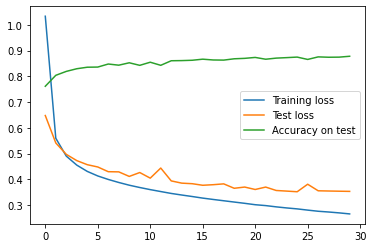

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Test loss')
plt.plot(scores, label='Accuracy on test')
plt.legend()

In [0]:
images, labels = next(iter(testloader))

# images batch has 64 images.
# test_image_id = 17  # shirt
test_image_id = 52  # sandal
# Reshape to one row.
img = images[test_image_id].view(1, -1) 

# Our image on CPU now.
model.to('cpu')

with torch.no_grad():
    logpreds = model(img)

<BarContainer object of 10 artists>

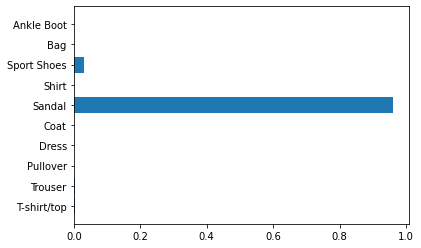

In [10]:
preds = torch.exp(logpreds)
n_preds = preds.numpy()[0]
FMNIST_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sport Shoes', 'Bag', 'Ankle Boot']
plt.yticks(np.arange(len(FMNIST_labels)), labels=FMNIST_labels)
plt.barh(np.arange(len(FMNIST_labels)), n_preds)

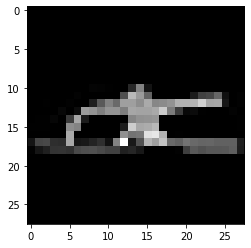

In [11]:
def denormalize(tensor):
    tensor = tensor*0.5 + 0.5
    return tensor
  
img = img.view(28, -1)
img = denormalize(img)
plt.imshow(img, cmap='gray')